In [1]:
import pandas as pd
import geopandas as gpd
import requests
import os
import shutil
import matplotlib.pyplot as plt
import sys
import numpy as np
import datetime
import folium
import shapely
import scipy
import skimage
from shapely.geometry import Polygon, MultiPolygon
from shapely.affinity import translate, scale
import datetime

## Load supporting data

In [159]:
COUNTY_LIST = {
    "Delaware":"041",
    "Fairfield":"045",
    "Fayette":"047",
    "Franklin":"049",
    "Hocking":"073",
    "Knox":"083",
    "Licking":"089",
    "Logan":"091",
    "Madison":"097",
    "Marion":"101",
    "Morrow":"117",
    "Perry":"127",
    "Pickaway":"129",
    "Ross":"141",
    "Union":"159"
}

In [173]:
region = gpd.read_file("./temp_data/region.shp")
region = region.to_crs(epsg=4326)
counties = gpd.read_file("./temp_data/counties.shp")
counties = counties.to_crs(epsg=4326)
tracts = gpd.read_file("./temp_data/tracts.shp")
tracts = tracts.to_crs(epsg=4326)
site = gpd.read_file("./input_data/site/site.shp")
site = site.to_crs(epsg=4326)
park_and_ride = gpd.read_file("./temp_data/park_and_ride.shp")
park_and_ride = park_and_ride.to_crs(epsg=4326)
points = gpd.read_file("./temp_data/tightpoints.shp")
points = points.to_crs(epsg=4326)
tract_points = gpd.read_file("./temp_data/tract_points.shp")
tract_points = tract_points.to_crs(epsg=4326)
blocks = gpd.read_file("./temp_data/blocks.shp")
blocks = blocks.to_crs(epsg=4326)

<AxesSubplot:>

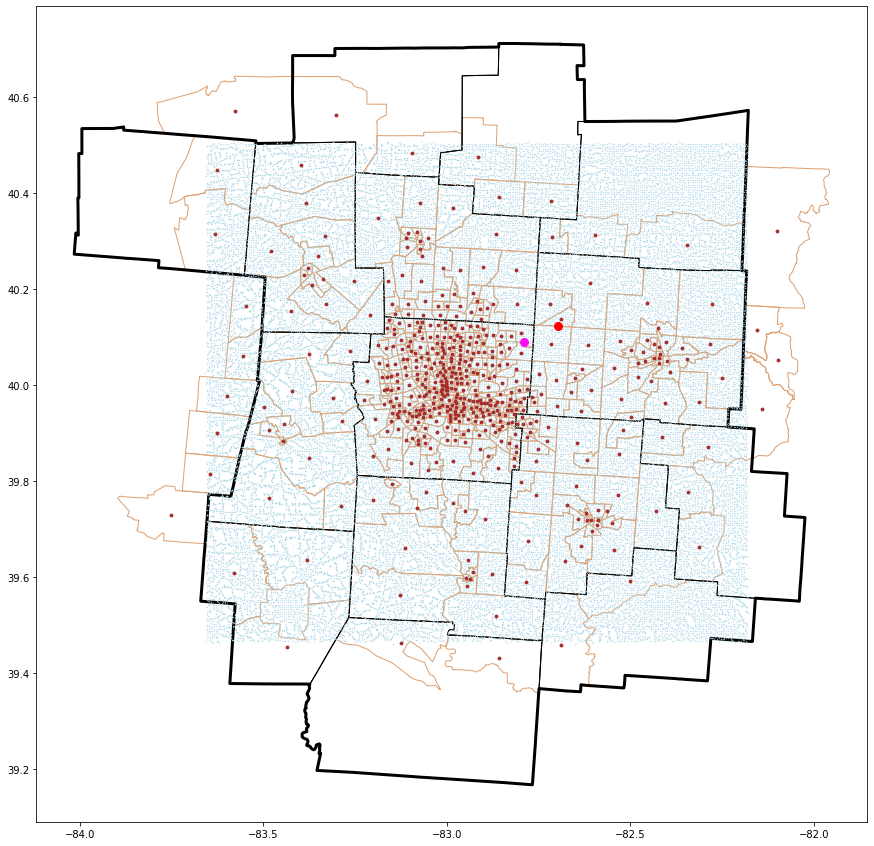

In [175]:
ax = tracts.plot(edgecolor="#dda071", facecolor="none", figsize=(15,15))
counties.plot(ax=ax, edgecolor="black", facecolor="none")
region.plot(ax=ax, linewidth=3, edgecolor="black", facecolor="none")
points.plot(ax=ax, color="lightblue", markersize=0.1)
tract_points.plot(ax=ax, color="brown", markersize=8)
site.plot(ax=ax, color="red", markersize=64)
park_and_ride.plot(ax=ax, color="#fc0cf4", markersize=64)

## Compute travel times between origin and destinations

In [61]:
ttm = pd.read_csv("./output_data/ttm_CAR_outbound_neighborhoods.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = tract_points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

m = counties.explore(tiles="OpenStreetMap", style_kwds={"color":"black", "weight":2, "fill":False})
ttm_points.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

## Create travel time isochrones

In [75]:
ttm = pd.read_csv("output_data/ttm_CAR_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [76]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [77]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [78]:
tightgrid["travel_time"] = z

<AxesSubplot:>

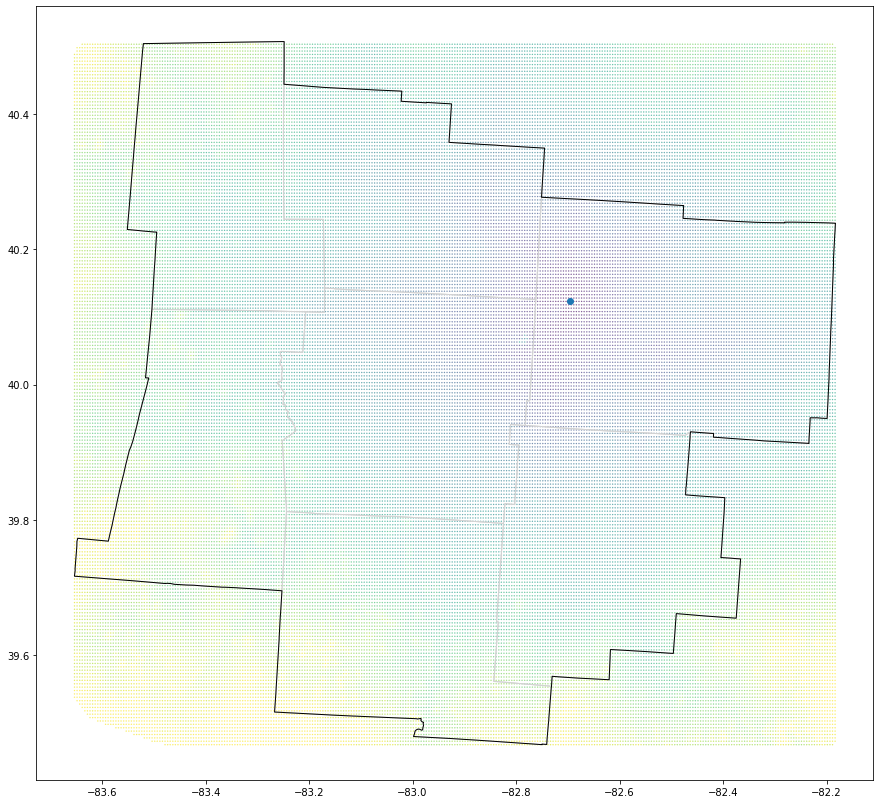

In [79]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.1, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [80]:
Z = z.reshape((len(y),len(x)))
#Z = np.nan_to_num(Z)
#Z = Z/Z.max()*255

Generating isochrone for budget 10
Generating isochrone for budget 20
Generating isochrone for budget 30
Generating isochrone for budget 40


,travel_time,geometry
3,40,"MULTIPOLYGON (((-82.18339 40.06147, -82.18706 ..."
2,30,"MULTIPOLYGON (((-82.75339 39.87764, -82.75381 ..."
1,20,"MULTIPOLYGON (((-82.72839 39.92969, -82.73230 ..."
0,10,"MULTIPOLYGON (((-82.72839 40.02793, -82.72951 ..."


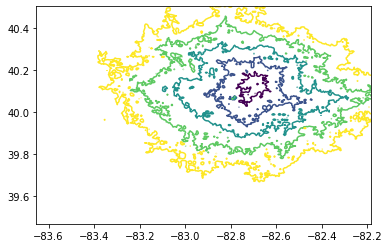

In [81]:
levels = [10,20,30,40,50]
contourList = []
contours = plt.contour(X,Y,Z, levels)

i = 0
for i in range(0, len(levels)-1):
    print("Generating isochrone for budget {}".format(levels[i]))
    thisContourList = []
    for contour in contours.allsegs[i]:
        try:
            poly = Polygon(contour)
        except:
            print("Warning: omitting incompatible geometry")
        thisContourList.append(poly)
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })
    
# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones

In [83]:
m = counties.explore(tiles="OpenStreetMap", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

## Create detailed itineraries

### Transit + shuttle or bike

In [36]:
itineraries = gpd.read_file("./output_data/itineraries_ANY_toconference_150.shp")
destination = 324
singleItinerary = itineraries.loc[(itineraries["toId"] == str(destination)) & (itineraries["option"] == 2)].copy()
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = tract_points.loc[tract_points["id"] == destination]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="OpenStreetMap", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 88.65 total, 80.51666666666665 travel, 8.133333333333333 wait
Walking distance (meters): 504
Biking distance (meters): 0


In [37]:
itineraries = gpd.read_file("./output_data/itineraries_SHUTTLE_TRANSIT_WALK_outbound_120.shp")
destination = 324
singleItinerary = itineraries.loc[itineraries["toId"] == str(destination)].copy()
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = tract_points.loc[tract_points["id"] == destination]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="OpenStreetMap", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 88.65 total, 76.69999999999999 travel, 11.95 wait
Walking distance (meters): 582
Biking distance (meters): 0


In [38]:
itineraries = gpd.read_file("./output_data/itineraries_SHUTTLE_firstmile.shp")
destination = 0
singleItinerary = itineraries.loc[itineraries["toId"] == str(destination)].copy()
singleItinerary["mode"] = singleItinerary["mode"].str.replace("CAR","SHUTTLE")
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = park_and_ride.loc[tract_points["id"] == destination]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="OpenStreetMap", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 13.3 total, 13.3 travel, 0.0 wait
Walking distance (meters): 0
Biking distance (meters): 0


## Appendix: Create grid of destination points

In [ ]:
raise RuntimeError

In [ ]:
GRIDSPACING = 0.01

In [ ]:
bounds = region.total_bounds

In [ ]:
xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

In [ ]:
x = np.arange(xmin, xmax, GRIDSPACING)

In [ ]:
y = np.arange(ymin, ymax, GRIDSPACING)

In [ ]:
X,Y = np.meshgrid(x,y)

In [ ]:
#coords = np.column_stack((X.ravel(), Y.ravel()))

In [ ]:
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(X.ravel(), Y.ravel()))
points = points.reset_index().rename(columns={"index":"id"})

In [ ]:
ax = points.plot(markersize=0.1, figsize=(10,10))
region.plot(ax=ax, edgecolor="black", facecolor="none")

In [ ]:
# not working
regionVertices = gpd.GeoSeries.from_xy(list(region.iloc[0]["geometry"].boundary.coords))
pointsSnapped = points.copy()
for index, row in points.iterrows():
    tmp_gdf = region.copy()
    tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])
    closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[1]
    # I took 1 because index 0 would be the row itself
    snapped_geom = snap(row['geometry'], closest_geom, 1)
    #snapped_geom = shapely.ops.snap(row['geometry'], region.iloc[0]["geometry"], 1)
    pointsSnapped.loc[index, 'geometry'] = snapped_geom

In [ ]:
intersections = streets.overlay(streets, how="intersection")

In [ ]:
intersections.to_file("./temp_data/intersections.shp")

In [ ]:
intersections.plot()

In [ ]:
list(streets.iloc[0]["geometry"].coords)

In [ ]:
foo = gpd.GeoSeries(shapely.ops.snap(points.loc[0]["geometry"], region.iloc[0]["geometry"], 1))

In [ ]:
ax = region.plot(facecolor="none")
pointsSnapped.plot(ax=ax)

In [ ]:
streets = gpd.read_file("./input_data/geofabrik_ohio-latest.gpkg", layer="lines")
streets = streets.loc[streets["highway"].notna()]

In [ ]:
streets.sindex

## Appendix: Create regional county boundaries dataset

In [ ]:
raise RuntimeError

In [154]:
counties_all = gpd.read_file("./input_data/counties/cb_2021_us_county_500k.shp")

In [160]:
counties_region = counties_all.loc[(counties_all["STATE_NAME"] == "Ohio") & (counties_all["COUNTYFP"].isin(COUNTY_LIST.values()))]

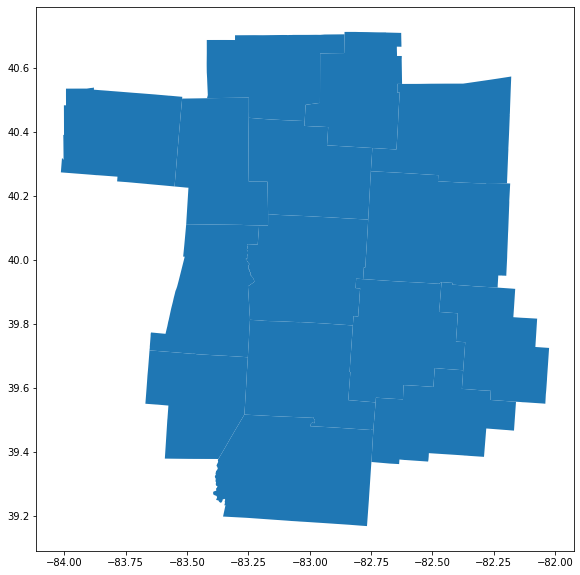

In [161]:
ax = counties_region.plot(figsize=(10,10))

In [162]:
counties_region.to_file("./temp_data/counties.shp")

## Appendix: Create region boundary dataset

In [ ]:
raise RuntimeError

<AxesSubplot:>

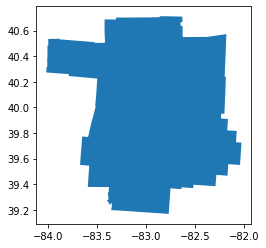

In [163]:
region = counties_region.dissolve()
region.plot()

In [164]:
region.to_file("./temp_data/region.shp")

## Appendix: Create tract boundaries and centroids datasets

In [206]:
tracts_all = gpd.read_file("./input_data/tracts/tl_2021_39_tract.shp")

tracts_region = gpd.sjoin(tracts_all.to_crs(epsg=3735), counties_region[["COUNTYFP","geometry"]].to_crs(epsg=3735), how='left', predicate='intersects', lsuffix='left', rsuffix='right')

tracts_region = tracts_region.loc[tracts_region["COUNTYFP_right"].notna()] \
    .filter(axis="columns", items=["GEOID", "COUNTYFP_left", "geometry"]) \
    .rename(columns={"GEOID_left":"GEOID"}) \
    .to_crs(epsg=4326)

tract_centroids = tracts_region.to_crs(epsg=3735).centroid.to_crs(epsg=4326)

tracts_region.to_file("./temp_data/tracts.shp")
tract_centroids.to_file("./temp_data/tract_centroids.shp")

ax = tracts_region.plot(figsize=(15,15))
tract_centroids.plot(ax=ax, color="black", markersize=4)
counties_region.plot(ax=ax, edgecolor="black", facecolor="none")

## Appendix: Download census population data

In [ ]:
raise RuntimeError

In [123]:
blocks_raw = gpd.read_file("./input_data/blocks/tl_2021_39_tabblock20.shp", dtype="object")

In [167]:
blocks = blocks_raw.copy()

In [168]:
blocks = blocks.loc[blocks["COUNTYFP20"].isin(COUNTY_LIST.values())]
blocks = blocks \
    .rename(columns={
        "COUNTYFP20":"COUNTYFP",
        "GEOID20":"GEOID"
    }) \
    .filter(axis="columns", items=["GEOID", "COUNTYFP", "geometry"])                                   

In [169]:
r = requests.get("https://api.census.gov/data/2020/dec/pl?get=GEO_ID,P1_001N&for=block:*&in=state:39%20county:{}".format(",".join(COUNTY_LIST.values())))
records = r.json()
columns = records.pop(0)
blockData = pd.DataFrame.from_records(records, columns=columns)
blockData.to_csv("./input_data/blocks/blockData.csv", index=False)

In [171]:
blockData = pd.read_csv("./input_data/blocks/blockData.csv", dtype="object")
blockData = blockData.loc[blockData["county"].isin(COUNTY_LIST.values())]
blockData["GEOID"] = blockData["GEO_ID"].apply(lambda x:x.split("US")[1])
blockData = blockData \
    .rename(columns={
        "county":"COUNTYFP",
        "P1_001N":"TOTALPOP"
    }) \
    .filter(axis="columns", items=["GEOID", "COUNTYFP", "TOTALPOP"])                                   

In [172]:
blocks = blocks \
    .merge(blockData, left_on="GEOID", right_on="GEOID") \
    .filter(axis="columns", items=["GEOID","COUNTYFP_x", "TOTALPOP", "geometry"]) \
    .rename(columns={"COUNTYFP_x":"COUNTYFP"})
blocks.to_file("./temp_data/blocks.shp")
blocks.head()

,GEOID,COUNTYFP,TOTALPOP,geometry
0,390970412003030,097,27,"POLYGON ((-83.27196 39.71246, -83.27196 39.712..."
1,390970412003005,097,94,"POLYGON ((-83.28681 39.71786, -83.28154 39.719..."
2,390970412002014,097,0,"POLYGON ((-83.25954 39.71574, -83.25571 39.718..."
3,390970411004019,097,1,"POLYGON ((-83.39468 39.89435, -83.39383 39.894..."
4,390970413001057,097,1,"POLYGON ((-83.59370 39.76228, -83.59240 39.762..."
